In [3]:
import xarray as xr
import matplotlib.pyplot as plt

In [4]:
ds = xr.open_dataset(r"D:\ESE5023\data\200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc")
print(ds)      

<xarray.Dataset> Size: 54MB
Dimensions:                  (time: 210, bnds: 2, lat: 36, lon: 72, pressure: 10)
Coordinates:
  * time                     (time) datetime64[ns] 2kB 2003-01-16T12:00:00 .....
  * lat                      (lat) float64 288B -87.5 -82.5 -77.5 ... 82.5 87.5
  * lon                      (lon) float64 576B -177.5 -172.5 ... 172.5 177.5
Dimensions without coordinates: bnds, pressure
Data variables:
    time_bnds                (time, bnds) datetime64[ns] 3kB ...
    lat_bnds                 (lat, bnds) float64 576B ...
    lon_bnds                 (lon, bnds) float64 1kB ...
    pre                      (pressure) float64 80B ...
    pre_bnds                 (pressure, bnds) float64 160B ...
    land_fraction            (lat, lon) float64 21kB ...
    xch4                     (time, lat, lon) float32 2MB ...
    xch4_nobs                (time, lat, lon) float64 4MB ...
    xch4_stderr              (time, lat, lon) float32 2MB ...
    xch4_stddev              (tim

In [5]:
# Question_1.1
xch4 = ds["xch4"]   
monthly_means = []  

for m in range(1, 13):   
    xch4_m = xch4.where(xch4["time"].dt.month == m, drop=True)
    xch4_m_mean = xch4_m.mean(dim="time", skipna=True)
    monthly_means.append(xch4_m_mean)
    
import numpy as np
month_coord = np.arange(1, 13)
xch4_clim = xr.concat(monthly_means, dim="month")
xch4_clim = xch4_clim.assign_coords(month=("month", month_coord))

print(xch4_clim.shape)  

(12, 36, 72)


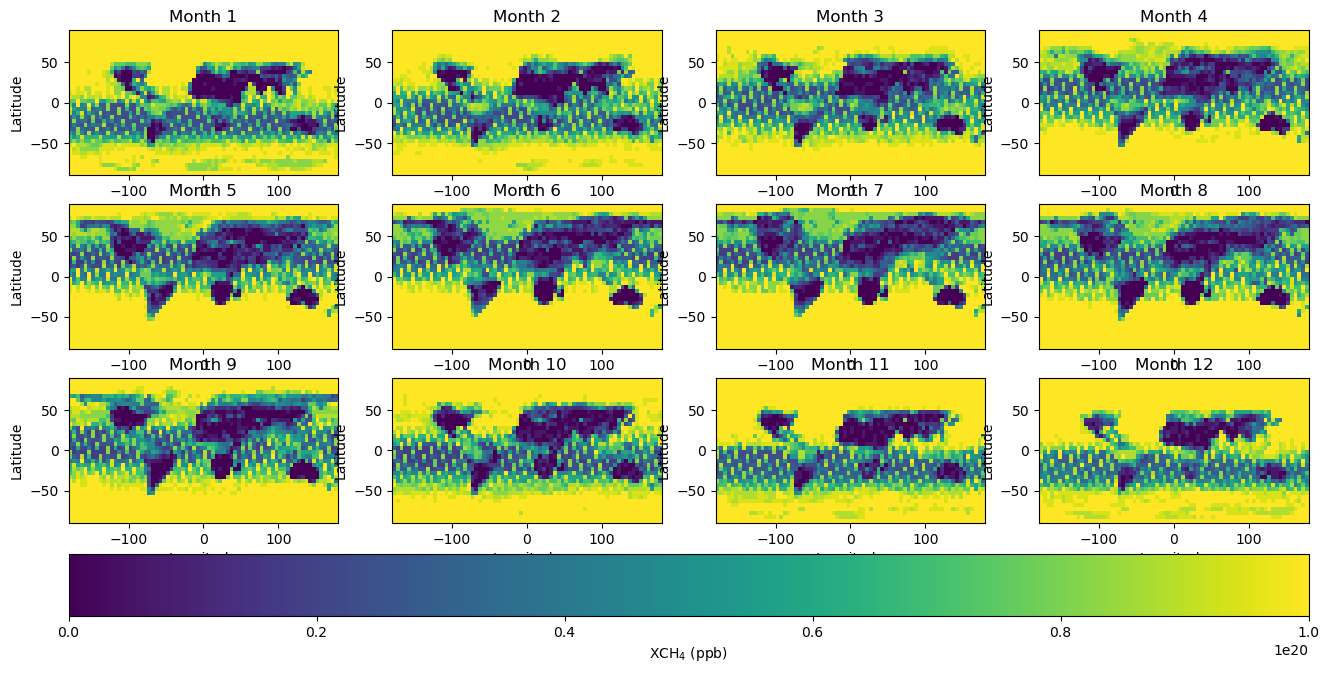

In [7]:
lats = ds["lat"]
lons = ds["lon"]

fig, axes = plt.subplots(3, 4, figsize=(16, 8))

for i in range(12):
    ax = axes[i // 4, i % 4]
    data = xch4_clim.isel(month=i)
    im = ax.pcolormesh(lons, lats, data, shading="auto")
    ax.set_title(f"Month {i+1}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation="horizontal", pad=0.05)
cbar.set_label("XCH$_4$ (ppb)")

plt.show()

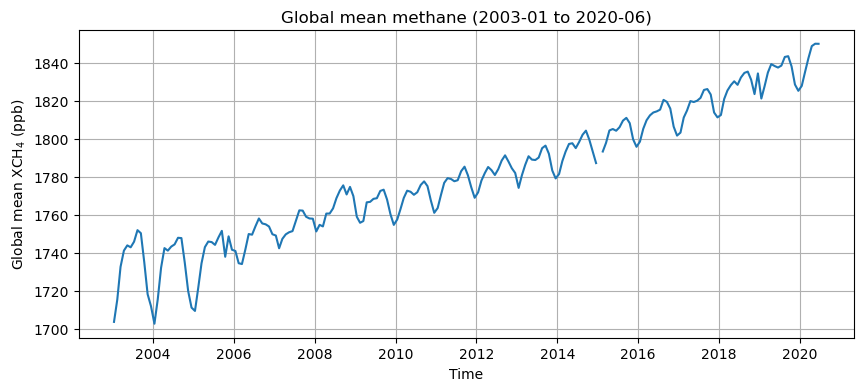

In [15]:
# Question_1.2
xch4 = ds["xch4"].where(ds["xch4"] < 1e6)
xch4_ppb = xch4 * 1e9

xch4_global = xch4_ppb.mean(dim=["lat", "lon"], skipna=True)
time = ds["time"]

plt.figure(figsize=(10, 4))
plt.plot(time, xch4_global)
plt.xlabel("Time")
plt.ylabel("Global mean XCH$_4$ (ppb)")
plt.title("Global mean methane (2003-01 to 2020-06)")
plt.grid(True)
plt.show()

**图中可以看到，从 2003 年到 2020 年，全球平均甲烷浓度整体呈明显上升趋势，大约从 1700 ppb 上升到接近 1900 ppb，在长期上升趋势之上，每年还有一圈较小的起伏，反映了甲烷的季节性变化。**

In [9]:
# Question_1.3
print(ds["lon"].min().item(), ds["lon"].max().item())

-177.5 177.5


In [11]:
target_lat = -15.0   
target_lon = -150.0  

pt = xch4.sel(lat=target_lat, lon=target_lon, method="nearest")
print(pt.shape)    

(210,)


In [12]:
pt_clim_month = pt.groupby("time.month").mean("time", skipna=True)
print(pt_clim_month)

<xarray.DataArray 'xch4' (month: 12)> Size: 96B
array([1.76493302e-06, 1.76284573e-06, 1.78111497e-06, 1.78382186e-06,
                  nan,            nan, 1.80173265e-06, 1.79574749e-06,
       1.76869071e-06, 1.75609637e-06, 1.76383219e-06, 1.76715537e-06])
Coordinates:
    lat      float64 8B -12.5
    lon      float64 8B -147.5
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:  dry_atmosphere_mole_fraction_of_methane
    long_name:      column-average dry-air mole fraction of atmospheric methane
    units:          1
    cell_methods:   time: mean
    fill_value:     1e+20
    comment:        Satellite retrieved column-average dry-air mole fraction ...


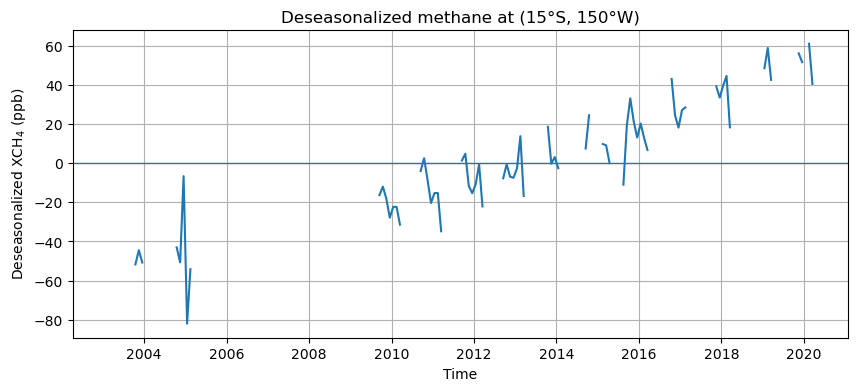

In [16]:
pt = xch4.sel(lat=-15.0, lon=-150.0, method="nearest") * 1e9  

pt_clim_month = pt.groupby("time.month").mean("time", skipna=True)
pt_deseasonal = pt.groupby("time.month") - pt_clim_month

plt.figure(figsize=(10, 4))
plt.plot(ds["time"], pt_deseasonal)
plt.xlabel("Time")
plt.ylabel("Deseasonalized XCH$_4$ (ppb)")
plt.title("Deseasonalized methane at (15°S, 150°W)")
plt.axhline(0, linewidth=1)
plt.grid(True)
plt.show()

**对 (15°S, 150°W) 点做去季节化之后，时间序列大致在 0 附近上下波动，说明季节循环已经被去掉。早期的去季节化值多为负，后期逐渐偏正，表明在去除季节效应之后，该点的甲烷背景水平仍然存在缓慢的上升趋势。图中间部分有一些缺测的时间段，可能与卫星观测条件有关。**

In [17]:
# Question_2.1
import xarray as xr
import matplotlib.pyplot as plt

ds = xr.open_dataset(r"D:\ESE5023\data\NOAA_NCDC_ERSST_v3b_SST.nc")
print(ds)

<xarray.Dataset> Size: 44MB
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 356B -88.0 -86.0 -84.0 -82.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 5kB 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 44MB ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...


In [18]:
print(ds["lon"].min().item(), ds["lon"].max().item())

0.0 358.0


In [19]:
sst = ds["sst"]
sst = sst.where((sst < 100) & (sst > -5))
lon_min, lon_max = 190, 240   
nino34_region = sst.sel(
    lat=slice(-5, 5),
    lon=slice(lon_min, lon_max)
)

nino34_ts = nino34_region.mean(dim=["lat", "lon"], skipna=True)
print(nino34_ts.shape)

(684,)


In [24]:
# 计算月气候态：对不同月份分组，在 time 上求平均
nino34_clim = nino34_ts.groupby("time.month").mean("time", skipna=True)

# 计算异常：每个时间点减去对应月份的平均
nino34_anom = nino34_ts.groupby("time.month") - nino34_clim

print(nino34_clim.shape)   
print(nino34_anom.shape)   
print(nino34_clim)
print(nino34_anom)

(12,)
(684,)
<xarray.DataArray 'sst' (month: 12)> Size: 96B
array([26.56811714, 26.74259949, 27.23990631, 27.69402695, 27.7955246 ,
       27.59807205, 27.19927216, 26.82458687, 26.73819542, 26.71751595,
       26.69366646, 26.61344528])
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
<xarray.DataArray 'sst' (time: 684)> Size: 5kB
array([-3.19578171e-01, -4.68517303e-01, -2.68152237e-01, -1.86965942e-01,
       -1.77598953e-01, -3.57694626e-01, -1.41969681e-01,  1.46522522e-02,
       -1.52212143e-01, -3.79865646e-01, -3.60893250e-01, -2.08692551e-01,
       -1.91471100e-01, -1.34279251e-01, -2.40375519e-01, -1.85125351e-01,
        5.19142151e-02,  2.39379883e-01, -7.03392029e-02, -4.18699265e-01,
       -7.78310776e-01, -7.92385101e-01, -4.96292114e-01, -4.17306900e-01,
       -4.44780350e-01, -4.55936432e-01, -4.36033249e-01, -4.66926575e-01,
       -5.64533234e-01, -4.26889420e-01, -2.76725769e-01, -3.17216873e-01,
       -6.73154831e-01, -6.66118622e-01, -8.

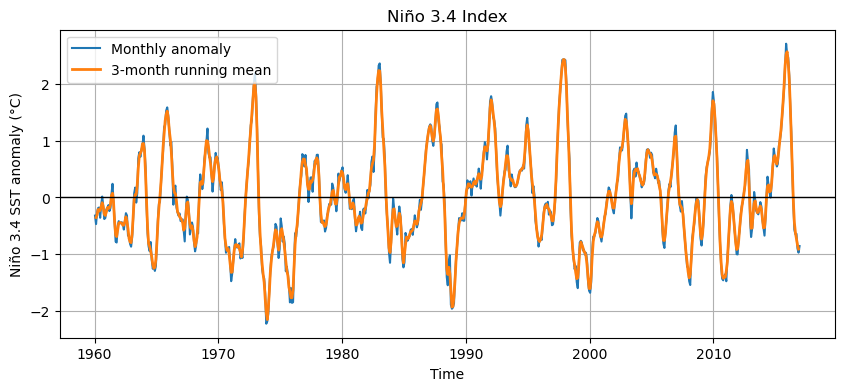

In [25]:
# Question_2.2
nino34_anom_3m = nino34_anom.rolling(time=3, center=True).mean()
time = ds["time"]

plt.figure(figsize=(10, 4))
plt.plot(time, nino34_anom, label="Monthly anomaly")
plt.plot(time, nino34_anom_3m, linewidth=2, label="3-month running mean")
plt.axhline(0, color="black", linewidth=1)  
plt.xlabel("Time")
plt.ylabel("Ni\u00f1o 3.4 SST anomaly (°C)")
plt.title("Ni\u00f1o 3.4 Index")
plt.grid(True)
plt.legend()
plt.show()

In [28]:
# Question_3
import xarray as xr
import matplotlib.pyplot as plt

ds = xr.open_dataset(r"D:\ESE5023\data\NOAA_NCDC_ERSST_v3b_SST.nc")
sst = ds["sst"]   
sst = sst.where((sst < 100) & (sst > -5))

time = ds["time"]
lat = ds["lat"]
lon = ds["lon"]

In [29]:
sst_global = sst.mean(dim=["lat", "lon"], skipna=True)  # (time,)
sst_global_clim = sst_global.groupby("time.month").mean("time", skipna=True)
sst_global_anom = sst_global.groupby("time.month") - sst_global_clim

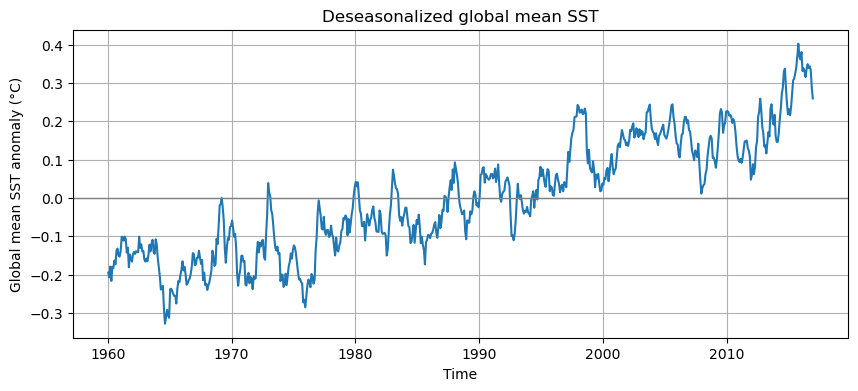

In [31]:
# Question_3.1
plt.figure(figsize=(10, 4))
plt.plot(time, sst_global_anom)
plt.axhline(0, color="gray", linewidth=1)
plt.xlabel("Time")
plt.ylabel("Global mean SST anomaly (°C)")
plt.title("Deseasonalized global mean SST")
plt.grid(True)
plt.show()

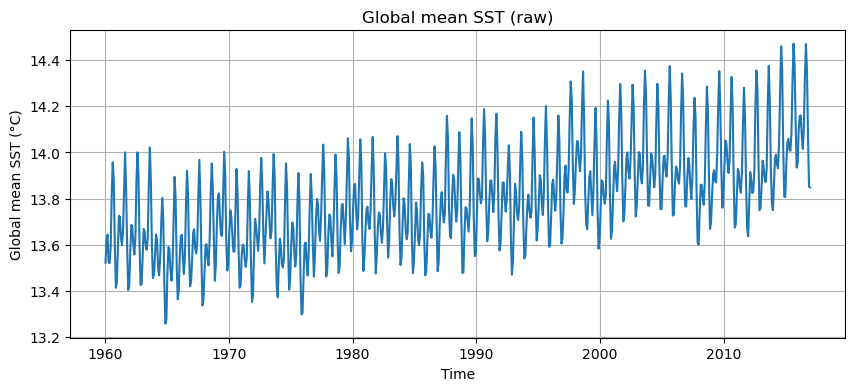

In [32]:
# Question_3.2
# 原始全球平均 SST 时间序列（没去季节）
plt.figure(figsize=(10, 4))
plt.plot(time, sst_global)
plt.xlabel("Time")
plt.ylabel("Global mean SST (°C)")
plt.title("Global mean SST (raw)")
plt.grid(True)
plt.show()

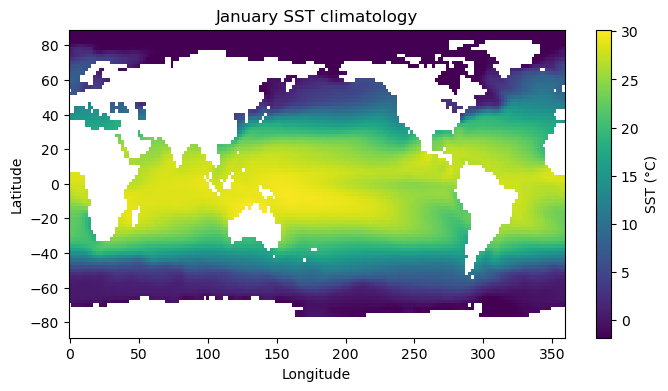

In [33]:
# 1月份的气候态空间分布
sst_monthly_clim = sst.groupby("time.month").mean("time", skipna=True)  
sst_jan_clim = sst_monthly_clim.sel(month=1)

plt.figure(figsize=(8, 4))
plt.pcolormesh(lon, lat, sst_jan_clim, shading="auto")
plt.colorbar(label="SST (°C)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("January SST climatology")
plt.show()

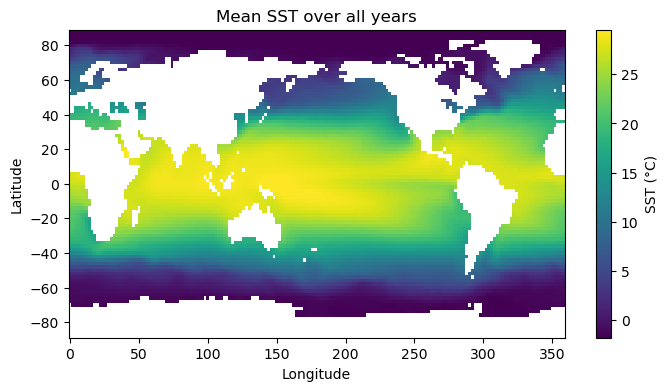

In [34]:
# 全年平均 SST 空间分布
sst_mean_map = sst.mean(dim="time", skipna=True)

plt.figure(figsize=(8, 4))
plt.pcolormesh(lon, lat, sst_mean_map, shading="auto")
plt.colorbar(label="SST (°C)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Mean SST over all years")
plt.show()

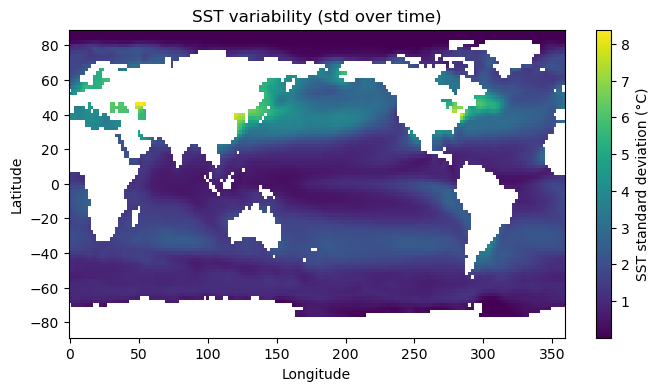

In [35]:
# SST 的标准差空间分布
sst_std_map = sst.std(dim="time", skipna=True)

plt.figure(figsize=(8, 4))
plt.pcolormesh(lon, lat, sst_std_map, shading="auto")
plt.colorbar(label="SST standard deviation (°C)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("SST variability (std over time)")
plt.show()

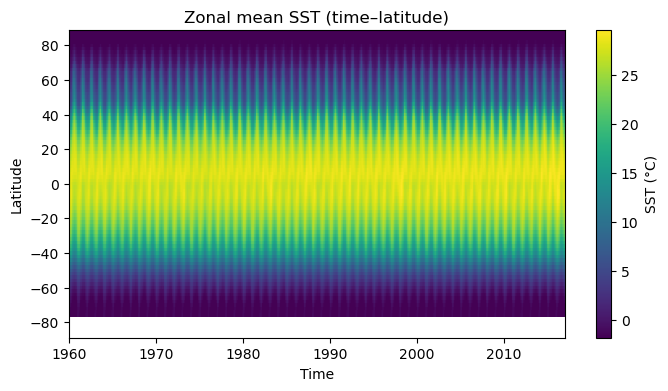

In [36]:
# 纬向平均的 Hovmöller 图
sst_zonal_mean = sst.mean(dim="lon", skipna=True)

plt.figure(figsize=(8, 4))
plt.pcolormesh(time, lat, sst_zonal_mean.T, shading="auto")  
plt.colorbar(label="SST (°C)")
plt.xlabel("Time")
plt.ylabel("Latitude")
plt.title("Zonal mean SST (time–latitude)")
plt.show()